In [58]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import networkx as nx
from scipy.optimize import minimize

from docplex.mp.model import Model
from collections import defaultdict
from openqaoa.problems.converters import FromDocplex2IsingModel # function to translate docplex problems into Ising Hamiltonians

import networkx as nx
import numpy as np
import time
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator

from qiskit_aer import AerSimulator

# backend = BasicSimulator()
backend = AerSimulator()

colors = plt.cm.get_cmap("jet", 20)

label_size = 14
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.labelsize'] = label_size 
plt.rcParams['legend.fontsize'] = label_size 

/var/folders/76/d4kyjysx1xgdrrs6zzs63s180000gn/T/ipykernel_23601/3946599748.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("jet", 20)


In [59]:
def MIS_QUBO(G, penalty=2):
    # MIS model as a QUBO problem
    mdl = Model('MIS')
    num_vertices = G.number_of_nodes()

    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum(x) + penalty * mdl.sum(
        x[i] * x[j] for (i, j) in G.edges
    ))
    return mdl

def cost(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            obj += 2
    return - x.count("1") + obj

def energy(x, hamiltonian):
    obj = 0
    spin = {"1":-1, "0":1}
    for k, v in hamiltonian.items():
        if len(k) == 2:
            obj += v * spin[x[k[0]]] * spin[x[k[1]]]
        elif len(k) == 1:
            obj += v * spin[x[k[0]]]
        else:
            print(k, v)
    return obj


def qaoa_circ(hamiltonian, gammas, betas, n_qubits):
    p = len(gammas)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    for ii in range(p):
        for qbits, value in hamiltonian.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[ii]*float(value), qbits[0])
        for qbits, value in hamiltonian.items():
            if len(qbits) == 2:
                qc.rzz(2*gammas[ii]*float(value), *qbits)
        qc.rx(-2*betas[ii], range(n_qubits))
    qc = qc.reverse_bits()
    qc.measure_all()
    return qc

In [31]:
np.random.seed(123)
problems = {}
nodes_list_qubo = range(5, 26)
prob_G = 0.4
random_cases = 100
# Generate graphs with the above condition for different number of nodes
for nodes in nodes_list_qubo: 
    print(f"-------     qubits: {nodes}    ---------")
    problems[nodes] = {}
    for kk in range(random_cases):
        problems[nodes][kk] = {}
        G = nx.Graph()
        G.add_nodes_from(range(nodes))
        for i in range(nodes - 1):
            for j in range(i+1, nodes):
                if np.random.rand() < prob_G:
                    G.add_edge(i,j)
        problems[nodes][kk]["G"] = G
        mdl = MIS_QUBO(G)
        ising_hamiltonian = FromDocplex2IsingModel(mdl).ising_model
        max_w = np.max(np.abs(ising_hamiltonian.weights))
        # max_w = np.max(np.abs([w for w, qbs in zip(ising_hamiltonian.weights, ising_hamiltonian.terms) if len(qbs)==2]))
        ising_hamiltonian.weights = [w/max_w for w in ising_hamiltonian.weights]
        ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
        problems[nodes][kk]["ising"] = {tuple(k): v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
        mdl.solve()
        problems[nodes][kk]["sol"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
        problems[nodes][kk]["opt_cost"] = cost(problems[nodes][kk]["sol"], G)
        problems[nodes][kk]["opt_energy"] = energy(problems[nodes][kk]["sol"], problems[nodes][kk]["ising"])#*max_w + max_w* ising_hamiltonian.constant

np.save("./Data/MIS/problems.npy", problems)

-------     qubits: 5    ---------
-------     qubits: 6    ---------
-------     qubits: 7    ---------
-------     qubits: 8    ---------
-------     qubits: 9    ---------
-------     qubits: 10    ---------
-------     qubits: 11    ---------
-------     qubits: 12    ---------
-------     qubits: 13    ---------
-------     qubits: 14    ---------
-------     qubits: 15    ---------
-------     qubits: 16    ---------
-------     qubits: 17    ---------
-------     qubits: 18    ---------
-------     qubits: 19    ---------
-------     qubits: 20    ---------
-------     qubits: 21    ---------
-------     qubits: 22    ---------
-------     qubits: 23    ---------
-------     qubits: 24    ---------
-------     qubits: 25    ---------


In [32]:
problems = np.load("./Data/MIS/problems.npy", allow_pickle=True).item()

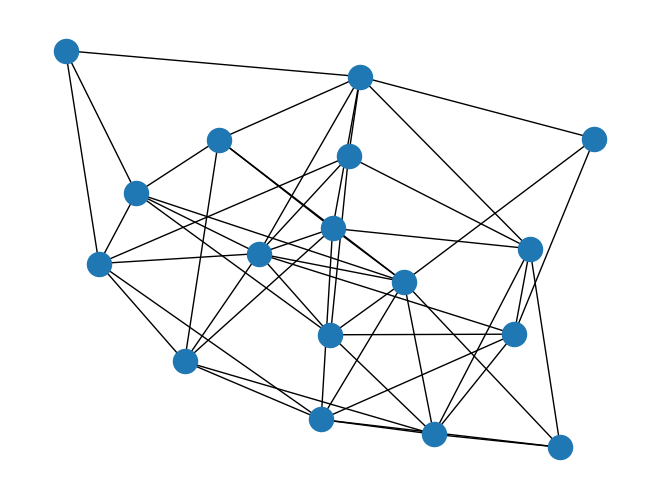

In [161]:
nx.draw(problems[17][0]["G"])

In [162]:
ps = [10,25,50,100,200]
delta_betas = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7]
delta_gammas = [0.5, 1.0, 2.0, 2.5, 3, 3.5, 4]
nqs = [19]
cases = [0]
shots = 100
results = np.load("./Data/MIS/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    results[nq] = {}
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        G = problems[nq][kk]["G"]
        results[nq][kk]["energies"] = {}
        results[nq][kk]["landscape"]={}
        results[nq][kk]["best"] = {}
        for p in ps:
            best_probability = 0
            print(f"---------   p = {p}   --------")
            results[nq][kk]["energies"][p] = {}
            results[nq][kk]["landscape"][p] = {"energy":np.zeros((len(delta_betas), len(delta_gammas))), "probability":np.zeros((len(delta_betas), len(delta_gammas)))}
            for i, delta_beta in enumerate(delta_betas):
                for j, delta_gamma in enumerate(delta_gammas):
                    gammas = np.arange(1, p+1) * delta_gamma/p
                    betas = np.arange(1, p+1)[::-1] * delta_beta/p
                    qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                    qc = transpile(qc, backend=backend)
                    samples = backend.run(qc, shots=shots).result().get_counts()
                    energies = defaultdict(int)
                    mean_energy = 0
                    for sample, c in samples.items():
                        e = round(energy(sample, hamiltonian), 3)
                        energies[e] += c
                        mean_energy += e*c
                    mean_energy /= shots 
                    probability = energies[opt_energy]/shots if opt_energy in energies else 0
                    results[nq][kk]["energies"][p][(delta_beta, delta_gamma)] = energies
                    results[nq][kk]["landscape"][p]["energy"][i,j] = mean_energy
                    results[nq][kk]["landscape"][p]["probability"][i,j] = probability
                    if probability > best_probability:
                        best_probability = probability
                        results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
                        print(f"beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
np.save("./Data/MIS/results.npy", results)

---------   nq = 19   --------
---------   case = 0   --------
---------   p = 10   --------
beta:0.2 | gamma: 2.5, probability: 0.04, mean energy: -4.792790000000002
beta:0.4 | gamma: 3, probability: 0.1, mean energy: -5.527240000000003
beta:0.4 | gamma: 3.5, probability: 0.11, mean energy: -5.559950000000002
beta:0.4 | gamma: 4, probability: 0.14, mean energy: -5.345450000000002
---------   p = 25   --------
beta:0.1 | gamma: 2.0, probability: 0.01, mean energy: -4.634589999999999
beta:0.1 | gamma: 2.5, probability: 0.04, mean energy: -4.227270000000002
beta:0.2 | gamma: 1.0, probability: 0.1, mean energy: -5.616330000000002
beta:0.2 | gamma: 2.0, probability: 0.19, mean energy: -5.6509
beta:0.3 | gamma: 2.5, probability: 0.31, mean energy: -5.794419999999999
beta:0.3 | gamma: 3, probability: 0.34, mean energy: -5.769040000000001
beta:0.3 | gamma: 3.5, probability: 0.35, mean energy: -5.7508300000000006
beta:0.4 | gamma: 3, probability: 0.41, mean energy: -5.801720000000002
beta:0.4 

In [156]:
results[nq][kk]["best"]

{10: {'probabiliy': 0.11,
  'delta_beta': 0.5,
  'delta_gamma': 3,
  'energy': -5.2625},
 25: {'probabiliy': 0.31,
  'delta_beta': 0.7,
  'delta_gamma': 3,
  'energy': -5.36},
 50: {'probabiliy': 0.38,
  'delta_beta': 0.4,
  'delta_gamma': 3,
  'energy': -5.5425},
 100: {'probabiliy': 0.65,
  'delta_beta': 0.4,
  'delta_gamma': 2.5,
  'energy': -5.595},
 200: {'probabiliy': 0.87,
  'delta_beta': 0.5,
  'delta_gamma': 2.5,
  'energy': -5.6575}}

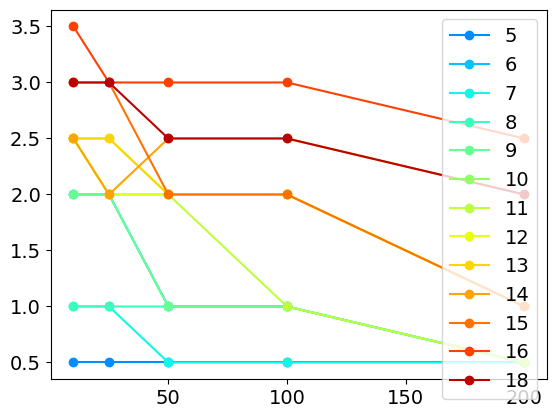

In [143]:
colors = plt.get_cmap("jet", 20)
for nq in results.keys():
    plt.plot(results[nq][kk]["best"].keys(), [results[nq][kk]["best"][p]["delta_gamma"] for p in results[nq][kk]["best"].keys()], marker="o",color= colors(nq), label=nq)
plt.legend()

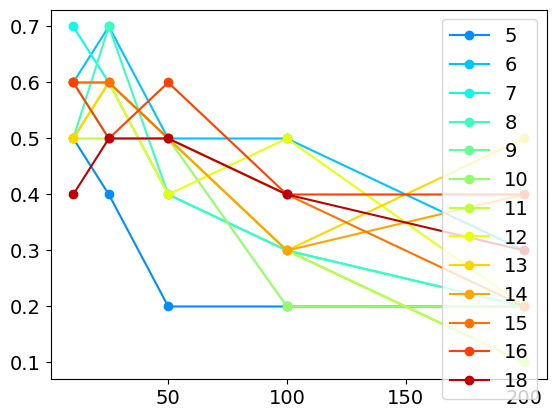

In [144]:
colors = plt.get_cmap("jet", 20)
for nq in results.keys():
    plt.plot(results[nq][kk]["best"].keys(), [results[nq][kk]["best"][p]["delta_beta"] for p in results[nq][kk]["best"].keys()], marker="o",color= colors(nq), label=nq)
plt.legend()

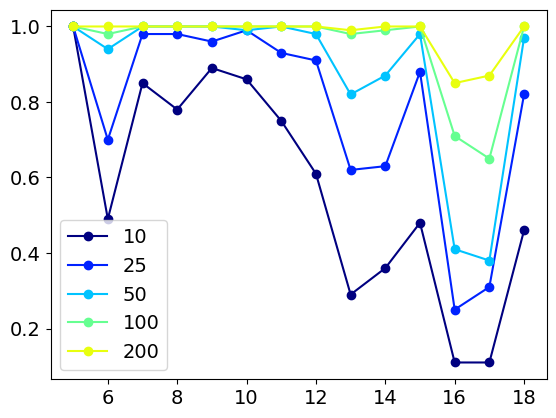

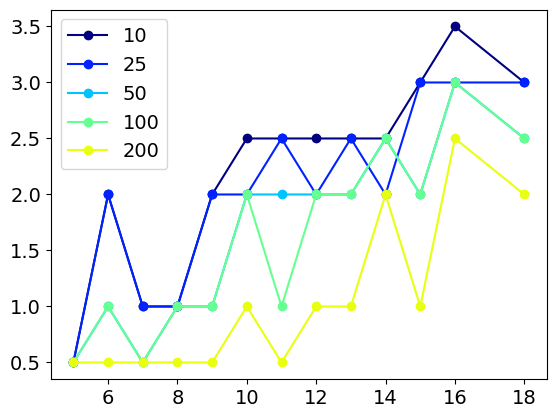

In [145]:
for i, p in enumerate(ps):
    plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_gamma"] for nq in results.keys()], marker="o", label=p, color=colors(3*i))
plt.legend()

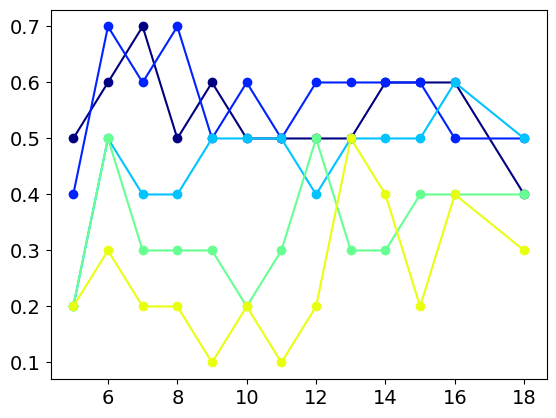

In [146]:

for i, p in enumerate(ps):
    plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o", label=p, color=colors(3*i))



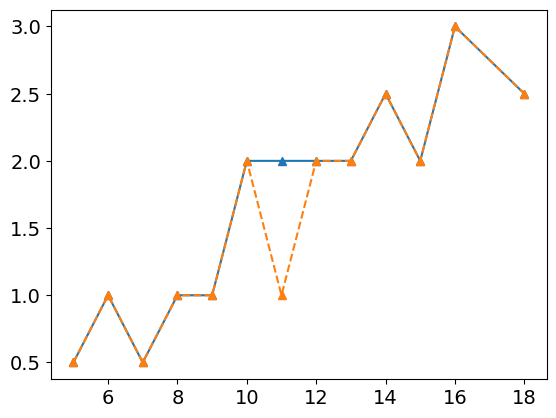

In [149]:
p=50
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_gamma"] for nq in results.keys()], marker="^")
p=100
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_gamma"] for nq in results.keys()], marker="^", linestyle="--")

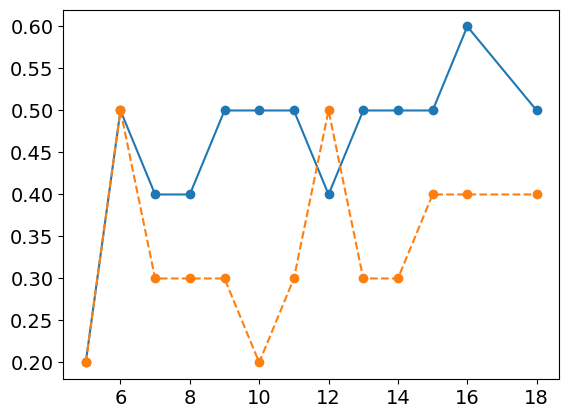

In [148]:
p=50
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o")
p=100
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o", linestyle="--")


In [85]:
results[nq][kk]["landscape"][p]["energy"]

array([[-5.266266, -5.253113, -5.196792, -5.156203, -5.10733 , -4.98474 ,
        -4.911587],
       [-5.270556, -5.284284, -5.28171 , -5.273988, -5.257411, -5.054265,
        -4.646544],
       [-5.245391, -5.28457 , -5.282854, -5.277998, -5.166275, -4.703126,
        -3.80368 ],
       [-5.208496, -5.283998, -5.280284, -5.228567, -5.073694, -4.118238,
        -2.830782],
       [-5.173899, -5.282282, -5.277428, -5.147417, -4.707956, -3.192761,
        -1.75957 ],
       [-5.133291, -5.281996, -5.22114 , -4.899973, -4.494245, -2.186405,
        -0.814943],
       [-5.100126, -5.278564, -5.136841, -4.709694, -3.688465, -1.258339,
        -0.206884]])

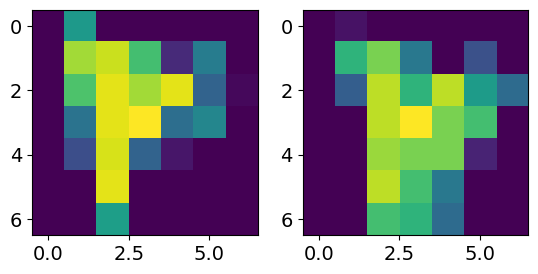

In [154]:
p = 100
nq = 18
fig, ax = plt.subplots(1,2)
ax[0].imshow(-results[nq][kk]["landscape"][p]["energy"], vmin=6, vmax=np.max(-results[nq][kk]["landscape"][p]["energy"]))
ax[1].imshow(results[nq][kk]["landscape"][p]["probability"], vmin= 0.8, vmax=np.max(results[nq][kk]["landscape"][p]["probability"]))

In [152]:
problems[nq][kk]["opt_energy"]


-6.1